In [1]:
import numpy as np
from IPython.display import Image, display

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2


## Practial approach: ODEs vs PDEs

+ ODEs you can usually get away with using built-in integration functions, unless you have a special type of equation (delay, integro-differential, etc.)
+ In my experience, you rarely have the same luck with PDEs. You usually have to write your own discretization and solver. 
+ If you are solving a very common PDE (Navier Stokes, Laplace, etc.) there might be external libraries that work in certain regimes, or which can help with meshing, etc. But even in very restricted regimes, the design of these tools is expensive and narrow (using Ansys, COMSOL, etc. is a whole specialization in itself)



# Boundary conditions

+ The boundary conditions are the conditions on the solution at the boundary of the domain, whether the domain is space or time
+ The boundary conditions are usually specified as a function of the independent variable(s) (e.g. time or space) on a subset of the domain


# Projecting onto basis functions

+ Instead of meshing space directly, project onto a finite set of basis functions that span the space
+ Basically like meshing in momentum space, if our PDE is in position space
+ The basis functions are usually chosen to be orthogonal, and our resulting dynamical variables are the amplitudes of various "modes"
+ Fourier basis functions are the most common (assumes domain is a torus), but there are many others. Chebyshev polynomials are another common choice for cases where the domain is a finite interval

<!-- ## The Diffusion Equation

+ A differential equation that is often used to model the diffusion of a quantity through a medium
+ Appears in many contexts, including heat transfer, fluid flow, diffusion of molecules
+ Even the Schrodinger equation is a special case of the diffusion equation
+ Given a scalar field $\rho(x)$, the diffusion equation is

$$\frac{\partial \rho}{\partial t} = \nabla^2 \rho$$
 -->


## The CFL condition for hyperbolic PDEs

+ The CFL condition is a condition on mesh size and the time step that must be satisfied for the numerical solution of a hyperbolic PDE to be stable
+ Suppose that we have the wave equation in one dimension:

$$\frac{\partial^2 \rho}{\partial t^2} = c^2 \frac{\partial^2 \rho}{\partial x^2}$$

where $c$ determines the speed of travelling waves. The CFL condition is

$$
c \frac{\Delta t}{\Delta x} \leq C_{max}
$$

+ Where the dimensionless Courant number $C_{max}$ is determined by our iteration scheme. 
+ As a rule of thumb $C_{max} \sim 1$, because $C_{max}$ can be interpreted as the number of mesh cells that a particle of $\rho$ traverses per integration time step (for an Euler time-stepping scheme and fixed mesh size, this is exact). Realistically, we want to stay a little bit below the CFL limit, because we don't want to be right on the edge of instability. A typical "safety factor" would be $0.7$
+ We use the CFL condition here for a hyperbolic PDE (wave equation), but in practice it's a good choice for PDEs that admit travelling solutions, like solitons or Fisher waves or advance. We need a well-defined speed $c$

More info to check out in Chris Rycroft's notes: additional work showing stability conditions for PDE solvers. Fourier modes on a finite mesh, stability occurs  when none of the modes grow exponentially with time. Extremely similar to analytical tools that people use to study Reaction-Diffusion equations (see Murray textbook vol II, chapter 3).

#  The Method of lines

+ Discretize the domain using finite differences, spectral projection, or something else, and then solve the resulting set of coupled ODEs in continuous time using a built-in ODE solver

### Burger's equation

+ A nonlinear partial differential equation describing the time evolution of a fluid

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$$

+ The solutions tend to evolve towards a shock wave, which are discontinuities in the velocity, but not in the density of the fluid


## Finite difference operators

The finite difference operators are the operators that we use to approximate the derivatives in the PDE

The central first-order finite difference operators in 1D has the form

$$\frac{\partial}{\partial x} \approx \frac{f(x + \Delta x / 2) - f(x - \Delta x / 2)}{\Delta x}$$

The central second-order finite difference operators in 1D has the form

$$\frac{\partial^2}{\partial x^2} \approx \frac{f(x + \Delta x) - 2 f(x) + f(x - \Delta x)}{\Delta x^2}$$

## Semi-discretization

+ The semi-discretization is the process of replacing the derivatives in the PDE with finite difference operators
+ The semi-discretized PDE is a set of coupled ODEs in continuous time
+ The semi-discretized PDE is usually solved using a built-in ODE solver

## The Crank-Nicolson method

+ A method for solving the semi-discretized PDE
$$\frac{\partial \rho}{\partial t} = \nabla^2 \rho$$




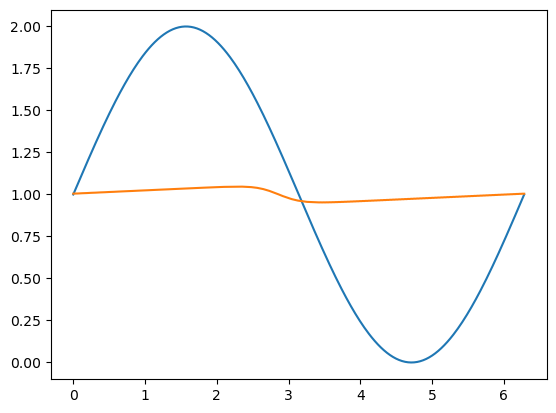

In [59]:
class BurgersEquationSpatialDiscretization:

    def __init__(self, x, t, u0, nu=1e-2):
        self.x = x
        self.t = t
        self.u0 = u0
        self.nu = nu

        self.dx = x[1] - x[0]

    def _derivative(self, u):
        du = u.copy()
        # central finite difference
        du[1:-1] = (u[2:] - u[:-2]) / (2 * self.dx)

        ## Periodic boundary conditions
        du[0] = (u[1] - u[-1]) / self.dx
        du[-1] = (u[0] - u[-2]) / self.dx

        ## Enforce reflection boundary conditions
        # du[0] = du[1]
        # du[-1] = du[-2]

        ## Enforce Dirichlet boundary conditions
        # du[0] = 0
        # du[-1] = 0

        return du

    def _laplacian(self, u):
        ddu = u.copy()
        ddu[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / self.dx**2

        ## Periodic boundary conditions with differences
        ddu[0] = (u[1] - 2 * u[0] + u[-1]) / self.dx**2
        ddu[-1] = (u[0] - 2 * u[-1] + u[-2]) / self.dx**2

        # ## Enforce reflection boundary conditions
        # ddu[0] = ddu[1]
        # ddu[-1] = ddu[-2]


        ## Enforce Dirichlet boundary conditions
        # du[0] = 0
        # du[-1] = 0

        return ddu

    def cfl(self, c=0.5):
        """Compute the Courant-Friedrichs-Lewy number for the current time step."""
        return c * self.dt / self.dx
        # return c * self.dx / np.max(np.abs(self.u0))

    def rhs(self, t, u):
        return self.nu * self._laplacian(u) - u * self._derivative(u)

    def __call__(self, *args, **kwargs):
        return self.rhs(*args, **kwargs)



x = np.linspace(0, 2 * np.pi, 300)
t = np.linspace(0, 50, 200)
u0 = 1 + np.sin(x)

eq = BurgersEquationSpatialDiscretization(x, t, u0)

from scipy.integrate import solve_ivp
sol = solve_ivp(eq, (t[0], t[-1]), u0, t_eval=t)

plt.plot(x, sol.y[:, 0])
plt.plot(x, sol.y[:, -1])
plt.show()


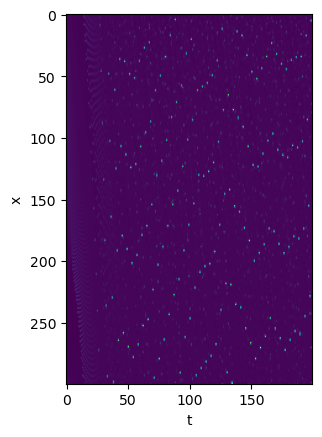

In [58]:
plt.imshow(sol.y)
plt.xlabel('t')
plt.ylabel('x')
plt.show()

### Boundary conditions

+ Explore how changing the boundary conditions in the above code (by commenting out the lines that set the boundary conditions) changes the solution properties
+ How does the diffusivity parameter affect the dynamics?

#### Types of boundary conditions

+ Dirichlet boundary conditions: the solution is specified at the boundary
+ Neumann boundary conditions: the derivative of the solution is specified at the boundary
+ Periodic boundary conditions: the solution is periodic in space
+ Mixed boundary conditions: a combination of the above



### Some specificities of Burgers equation

+ Shock waves are discontinuities in the velocity, but not in the density
+ The shock wave is a discontinuity in the derivative of the velocity
+ Propagate ballistically, i.e. at a constant speed of sound in the fluid
+ Characteristics: initial conditions get "carried" with the flow


### Transformation onto a linear equation

+ Burgers equation is a nonlinear PDE, but it can be transformed into a linear PDE by introducing a new variable

The Cole-Hopf transformation implies that we can substitute the variable $u(x)$ with $\phi(x)$ using the following defintion
$$
u=-2\nu {\frac {1}{\phi }}{\frac {\partial \phi }{\partial x}}
$$

Inserting this into the viscous Burgers equation gives
$$
{\frac {\partial }{\partial x}}\left({\frac {1}{\phi }}{\frac {\partial \phi }{\partial t}}\right)=\nu {\frac {\partial }{\partial x}}\left({\frac {1}{\phi }}{\frac {\partial ^{2}\phi }{\partial x^{2}}}\right)
$$
After some algebraic manipulation, we get
$$
{\frac {\partial \phi }{\partial t}}=\nu {\frac {\partial ^{2}\phi }{\partial x^{2}}}
$$
This is a linear diffusion equation, which we've already seen many methods of solving. We can solve this simplified heat equation, and then cast back into the original variables by performing the inverse transformation
$$
u(x,t)=-2\nu {\frac {\partial }{\partial x}}\ln \left\{(4\pi \nu t)^{-1/2}\int _{-\infty }^{\infty }\exp \left[-{\frac {(x-x')^{2}}{4\nu t}}-{\frac {1}{2\nu }}\int _{0}^{x'}f(x'')dx''\right]dx'\right\}.
$$


#### Takeaway: unlike our chaotic systems, the complexity of the dynamics of the Burgers equation is not intrinsic, but rather due to our choice of dynamical variables

+ In machine learning, is a problem intrinsically hard, or do we just need to pick the right coordinates?

### Burger's equation in the spectral domain

+ Instead of defining our mesh in space, we can instead discretize our field by projecting it onto a series of basis functions
+ Our ODEs after discretization will discribe the time evolution of the relative amplitudes of the basis functions
+ This is basically like transforming, and then discretizing in the transformed space

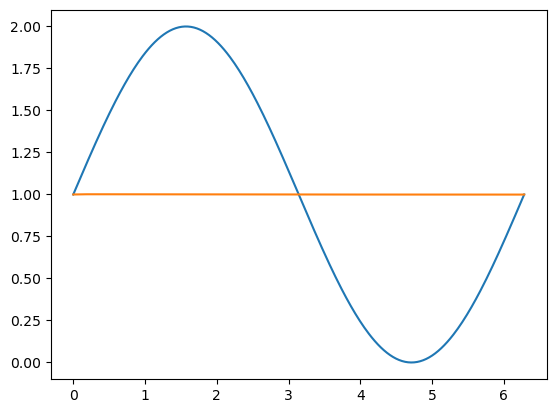

In [34]:
class BurgersEquationSpectral:
    """
    Solve Burger's equation purely within the Spectral domain
    """

    def __init__(self, x, t, u0, nu=1e-2):
        self.x = x
        self.t = t
        self.u0 = u0
        self.nu = nu

        self.dx = x[1] - x[0]

        self.k = np.fft.fftfreq(x.size, d=self.dx)
        self.k[0] = 1e-16 # avoid division by zero

    def _derivative(self, u):
        return 1j * self.k * u

    def _laplacian(self, u):
        return -self.k**2 * u

    def rhs(self, t, u):
        return self.nu * self._laplacian(u) - u * self._derivative(u)

    def __call__(self, *args, **kwargs):
        return self.rhs(*args, **kwargs)



x = np.linspace(0, 2 * np.pi, 300)
t = np.linspace(0, 50, 200)
u0 = 1 + np.sin(x)

# convert initial condition to spectral domain
u0 = np.fft.fft(u0)

eq = BurgersEquationSpectral(x, t, u0)

from scipy.integrate import solve_ivp
sol = solve_ivp(eq, (t[0], t[-1]), u0, t_eval=t)

# convert back to physical space
sol.y = np.fft.ifft(sol.y, axis=0).real

plt.plot(x, sol.y[:, 0])
plt.plot(x, sol.y[:, -1])
plt.show()





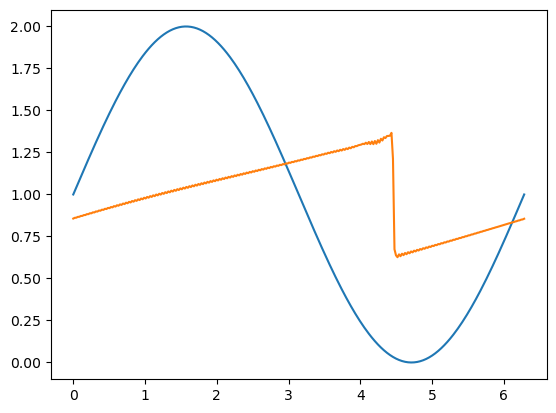

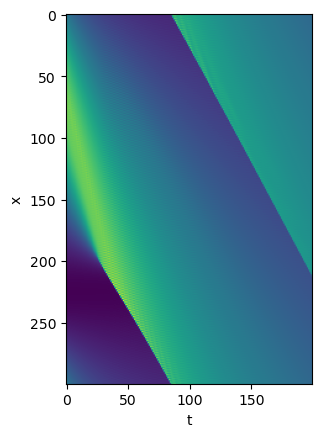

In [35]:
class BurgersEquationSpectral:

    def __init__(self, x, t, u0, nu=1e-2):
        self.x = x
        self.t = t
        self.u0 = u0
        self.nu = nu

        self.dx = x[1] - x[0]

        self.k = np.fft.fftfreq(len(x), d=self.dx)
        self.k[0] = 1e-16 # avoid division by zero

    def _derivative(self, u):
        return np.fft.ifft(1j * self.k * np.fft.fft(u))

    def _laplacian(self, u):
        return np.fft.ifft(-self.k**2 * np.fft.fft(u))

    def rhs(self, t, u):
        return self.nu * self._laplacian(u) - u * self._derivative(u)

    def __call__(self, *args, **kwargs):
        return self.rhs(*args, **kwargs)



x = np.linspace(0, 2 * np.pi, 300)
t = np.linspace(0, 50, 200)
u0 = 1 + np.sin(x)

eq = BurgersEquationSpectral(x, t, u0)

from scipy.integrate import solve_ivp
sol = solve_ivp(eq, (t[0], t[-1]), u0, t_eval=t)

plt.plot(x, sol.y[:, 0])
plt.plot(x, sol.y[:, -1])
plt.show()


plt.imshow(sol.y)
plt.xlabel('t')
plt.ylabel('x')
plt.show()




## What are the appropriate basis functions? 

+ Usually, we pick basis functions that form an orthogonal set, and which are consistent with our boundary conditions
+ So far, we've been using the Fourier basis functions and periodic boundary conditions


## The Chebyshev basis functions

+ For Dirichlet boundary conditions, we can use the Chebyshev basis functions, which are a set of functions that vanish or approach constant values at the boundary
+ The Chebyshev basis functions are a set of orthogonal functions that are defined on the interval $[-1, 1]$
+ The Chebyshev basis functions are defined recursively
$$T_0(x) = 1$$
$$T_1(x) = x$$
$$T_{n+1}(x) = 2xT_n(x) - T_{n-1}(x)$$

## Legendre basis functions

+ Another option Dirichlet boundary conditions, we can use the Chebyshev basis functions, which are a set of functions that vanish or approach constant values at the boundary
+ The Legendre basis functions are a set of orthogonal functions that are defined on the interval $[-1, 1]$
+ The Legendre basis functions are defined recursively
$$P_0(x) = 1$$
$$P_1(x) = x$$
$$P_{n+1}(x) = \frac{2n+1}{n+1}xP_n(x) - \frac{n}{n+1}P_{n-1}(x)$$




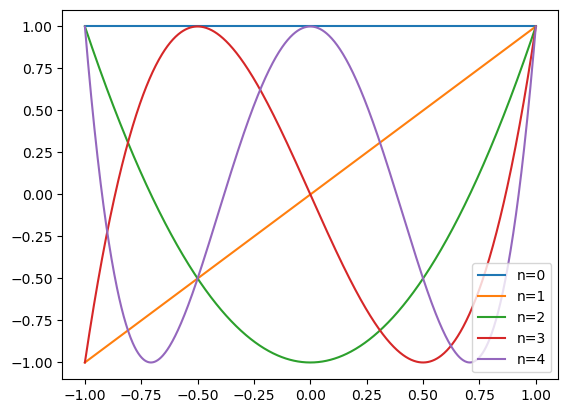

In [36]:
### Plot example Chebyshev polynomials

from scipy.special import eval_chebyt

x = np.linspace(-1, 1, 1000)
for n in range(5):
    plt.plot(x, eval_chebyt(n, x), label=f'n={n}')

plt.legend()
plt.show()


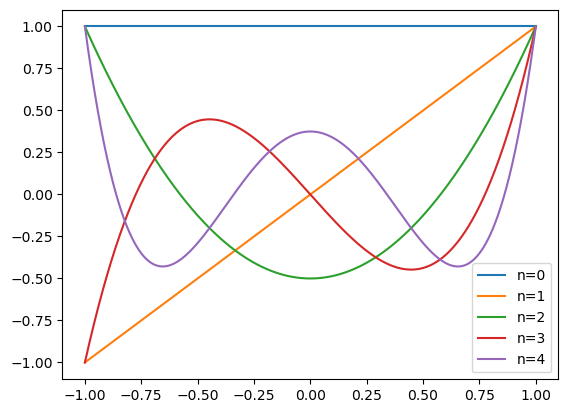

In [37]:
### Plot example Legendre polynomials

from scipy.special import eval_legendre

x = np.linspace(-1, 1, 1000)
for n in range(5):
    plt.plot(x, eval_legendre(n, x), label=f'n={n}')

plt.legend()
plt.show()



In [ ]:
# Solve the KuramotoSivashinsky equation with spectral methods

from scipy.integrate import solve_ivp

class KuramotoSivashinskyEquationSpectral:

    def __init__(self, x, t, u0, nu=1.0):
        self.x = x
        self.t = t
        self.u0 = u0
        self.nu = nu

    def rhs(self, t, u):
        u = u.reshape((len(self.x), 1))
        du = np.fft.fft(u, axis=0)
        ddu = np.fft.fft(du, axis=0)
        return -self.nu * du + ddu

    def solve(self):
        u0 = np.fft.fft(self.u0)
        sol = solve_ivp(self.rhs, (self.t[0], self.t[-1]), u0, t_eval=self.t)
        return np.real(np.fft.ifft(sol.y, axis=0))


In [61]:
# https://scicomp.stackexchange.com/questions/37336/solving-numerically-the-1d-kuramoto-sivashinsky-equation-using-spectral-methods
class KuramotoSivashinskySpectral:

    def __init__(self, x, t, u0, nu=1.0):
        self.x = x
        self.t = t
        self.u0 = u0
        self.nu = nu

        self.dx = x[1] - x[0]
        self.dt = t[1] - t[0]

        self.k = np.fft.fftfreq(len(x), d=self.dx)
        self.k2 = self.k**2
        self.k4 = self.k**4

    def rhs(self, t, u):
        u = u.reshape((len(self.x), 1))
        du = np.fft.fft(u, axis=0)
        ddu = np.fft.fft(du, axis=0)
        return -self.nu * du + ddu

    def solve(self):
        u0 = np.fft.fft(self.u0)
        sol = solve_ivp(self.rhs, (self.t[0], self.t[-1]), u0, t_eval=self.t)
        return np.real(np.fft.ifft(sol.y, axis=0))


x = np.linspace(0, 2 * np.pi, 300)
t = np.linspace(0, 50, 200)
u0 = 1 + np.sin(x)

eq = KuramotoSivashinskySpectral(x, t, u0)
sol = eq.solve()

plt.plot(x, sol[:, 0])
plt.plot(x, sol[:, -1])
plt.show()


ValueError: cannot reshape array of size 90000 into shape (300,1)

In [ ]:
class WaveEquation:

    def __init__(self, x, t, c, dx, dt):
        self.x = x
        self.t = t
        self.c = c
        self.dx = dx
        self.dt = dt
        self.dt2 = dt ** 2
        self.dx2 = dx ** 2
        self.nx = len(x)
        self.nt = len(t)
        self.u = np.zeros((self.nx, self.nt))
        self.u[0, :] = 0
        self.u[-1, :] = 0
        self.u[:, 0] = 0
        self.u[:, 1] = 0
        self.u[:, 2] = 0

    def solve(self):
        for i in range(2, self.nt - 1):
            for j in range(1, self.nx - 1):
                self.u[j, i + 1] = 2 * self.u[j, i] - self.u[j, i - 1] + \
                    self.c ** 2 * self.dt2 / self.dx2 * (self.u[j + 1, i] - 2 * self.u[j, i] + self.u[j - 1, i])



## Galerkin methods

+ Galerkin methods are a way to solve PDEs by projecting the PDE onto a basis of functions
+ The projection is done by solving a set of ODEs, which are the equations that the basis functions satisfy
+ The solution to the PDE is then the amplitudes of the basis functions
+ The ODEs are usually solved using a numerical method, such as Runge-Kutta
+ The basis functions are usually chosen to be orthogonal, so that the amplitudes are the coefficients of the expansion of the solution in the basis

In [ ]:
class GalerkinWaveEquation:

    def __init__(self, x, t, c, dx, dt):
        self.x = x
        self.t = t
        self.c = c
        self.dx = dx
        self.dt = dt
        self.dt2 = dt ** 2
        self.dx2 = dx ** 2
        self.nx = len(x)
        self.nt = len(t)
        self.u = np.zeros((self.nx, self.nt))
        self.u[0, :] = 0
        self.u[-1, :] = 0
        self.u[:, 0] = 0
        self.u[:, 1] = 0
        self.u[:, 2] = 0

    def solve(self):
        for i in range(2, self.nt - 1):
            for j in range(1, self.nx - 1):
                self.u[j, i + 1] = 2 * self.u[j, i] - self.u[j, i - 1] + \
                    self.c ** 2 * self.dt2 / self.dx2 * (self.u[j + 1, i] - 2 * self.u[j, i] + self.u[j - 1, i])


def plot_wave_equation(x, t, u):
    plt.figure(figsize=(10, 10))
    plt.imshow(u, extent=[x[0], x[-1], t[-1], t[0]], aspect='auto')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.colorbar()
    plt.show()


def plot_galerkin_wave_equation(x, t, u):
    plt.figure(figsize=(10, 10))
    plt.imshow(u, extent=[x[0], x[-1], t[-1], t[0]], aspect='auto')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.colorbar()
    plt.show()


def plot_galerkin_wave_equation(x, t, u):

# Dedalus

+ Dedalus is a Python package for solving PDEs using spectral methods
+ Very recently published ([Burns et al Phys Rev Research 2019](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.2.023068))

+ Idea: specify our PDE in a high-level symbolic language, and then Dedalus will automatically generate optimized code to solve it

+ Hardware configuration and dependencies

+ Other "high-level" PDE solvers exist, especially for finite-element methods (Ansys, COMSOL, etc), but Dedalus is high quality, actively maintained (difficult to find in academic software), and completely open-source

#### Installation

+ Instructions [here](https://dedalus-project.readthedocs.io/en/latest/pages/installation.html)
+ Dedalus has a lot of dependencies, so it's best to install it in a conda environment
+ On my Apple Silicon laptop, I had to use the [second set of instructions for custom conda installation here](https://dedalus-project.readthedocs.io/en/latest/pages/installation.html) to install Dedalus

### The Kuramoto-Sivashinsky equation

+ A nonlinear PDE that is a generalization of the Burgers equation that describes the dynamics of flame fronts
+ The solution of the Kuramoto-Sivashinsky equation is a soliton, which is a localized wave packet that moves at a constant speed

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2} + \frac{\partial^4 u}{\partial x^4}$$

We can convert this equation into the frequency domain by performing a Fourier transform, and then we can solve the resulting equation in the frequency domain. The solution is a soliton, which is a localized wave packet that moves at a constant speed.

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2} + \frac{\partial^4 u}{\partial x^4}$$


2022-10-12 19:43:55,127 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.4e+01/s
2022-10-12 19:43:55,256 __main__ 0/1 INFO :: Iteration=500, Time=1.000000e+00, dt=2.000000e-03


/var/folders/xt/9wdl4pmx26gf_qytq8_d528c0000gq/T/ipykernel_91279/1414699374.py:43: RuntimeWarning: overflow encountered in square
  u['g'] = np.log(1 + np.cosh(n)**2/np.cosh(n*(x-0.2*Lx))**2) / (2*n)


2022-10-12 19:43:55,382 __main__ 0/1 INFO :: Iteration=1000, Time=2.000000e+00, dt=2.000000e-03
2022-10-12 19:43:55,503 __main__ 0/1 INFO :: Iteration=1500, Time=3.000000e+00, dt=2.000000e-03
2022-10-12 19:43:55,627 __main__ 0/1 INFO :: Iteration=2000, Time=4.000000e+00, dt=2.000000e-03
2022-10-12 19:43:55,775 __main__ 0/1 INFO :: Iteration=2500, Time=5.000000e+00, dt=2.000000e-03
2022-10-12 19:43:55,920 __main__ 0/1 INFO :: Iteration=3000, Time=6.000000e+00, dt=2.000000e-03
2022-10-12 19:43:56,068 __main__ 0/1 INFO :: Iteration=3500, Time=7.000000e+00, dt=2.000000e-03
2022-10-12 19:43:56,210 __main__ 0/1 INFO :: Iteration=4000, Time=8.000000e+00, dt=2.000000e-03
2022-10-12 19:43:56,336 __main__ 0/1 INFO :: Iteration=4500, Time=9.000000e+00, dt=2.000000e-03
2022-10-12 19:43:56,460 __main__ 0/1 INFO :: Iteration=5000, Time=1.000000e+01, dt=2.000000e-03
2022-10-12 19:43:56,582 __main__ 0/1 INFO :: Iteration=5500, Time=1.100000e+01, dt=2.000000e-03
2022-10-12 19:43:56,704 __main__ 0/1 INF

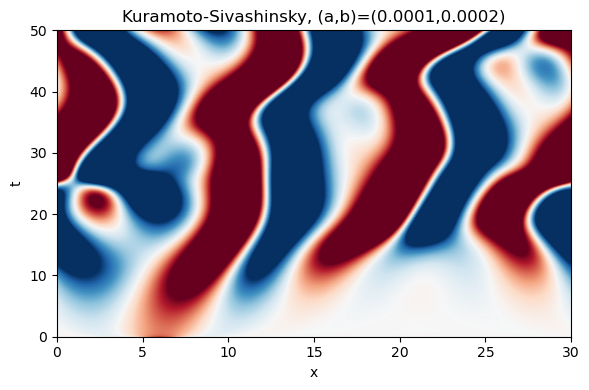

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)


# Parameters
Lx = 30
Nx = 1024
a = 1e-4
b = 2e-4
dealias = 3/2
stop_sim_time = 50
timestepper = d3.SBDF2
timestep = 2e-3
dtype = np.float64

# Bases: periodic
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=dtype)
xbasis = d3.RealFourier(xcoord, size=Nx, bounds=(0, Lx), dealias=dealias)

# Fields
u = dist.Field(name='u', bases=xbasis)

# Define operators
dx = lambda A: d3.Differentiate(A, xcoord)

# Problem
problem = d3.IVP([u], namespace=locals())
# problem.add_equation("dt(u) - a*dx(dx(u)) - b*dx(dx(dx(u))) = - u*dx(u)")
problem.add_equation("dt(u) + dx(dx(dx(dx(u)))) + dx(dx(u)) = -u*dx(u)")


# ic = gaussian_filter1d(np.random.random(x.shape), 10)
# dx_val = (2*np.pi)/len(u['g'])
# u['g'] = ic/(np.sum(ic)*dx_val)

# Initial conditions
x = dist.local_grid(xbasis)
n = 20
u['g'] = np.log(1 + np.cosh(n)**2/np.cosh(n*(x-0.2*Lx))**2) / (2*n)

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Main loop
u.change_scales(1)
u_list = [np.copy(u['g'])]
t_list = [solver.sim_time]
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    if solver.iteration % 50 == 0:
        u.change_scales(1)
        u_list.append(np.copy(u['g']))
        t_list.append(solver.sim_time)

# Plot
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_list), np.array(u_list), cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(-0.8, 0.8))
plt.xlim(0, Lx)
plt.ylim(0, stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title(f'Kuramoto-Sivashinsky, (a,b)=({a},{b})')
plt.tight_layout()
# plt.savefig('kdv_burgers.pdf')
# plt.savefig('kdv_burgers.png', dpi=200)

2022-10-12 19:44:22,617 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+01/s
2022-10-12 19:44:22,750 __main__ 0/1 INFO :: Iteration=500, Time=1.000000e+00, dt=2.000000e-03
2022-10-12 19:44:22,874 __main__ 0/1 INFO :: Iteration=1000, Time=2.000000e+00, dt=2.000000e-03
2022-10-12 19:44:23,000 __main__ 0/1 INFO :: Iteration=1500, Time=3.000000e+00, dt=2.000000e-03
2022-10-12 19:44:23,124 __main__ 0/1 INFO :: Iteration=2000, Time=4.000000e+00, dt=2.000000e-03
2022-10-12 19:44:23,249 __main__ 0/1 INFO :: Iteration=2500, Time=5.000000e+00, dt=2.000000e-03
2022-10-12 19:44:23,375 __main__ 0/1 INFO :: Iteration=3000, Time=6.000000e+00, dt=2.000000e-03
2022-10-12 19:44:23,498 __main__ 0/1 INFO :: Iteration=3500, Time=7.000000e+00, dt=2.000000e-03
2022-10-12 19:44:23,623 __main__ 0/1 INFO :: Iteration=4000, Time=8.000000e+00, dt=2.000000e-03
2022-10-12 19:44:23,747 __main__ 0/1 INFO :: Iteration=4500, Time=9.000000e+00, dt=2.000000e-03
2022-

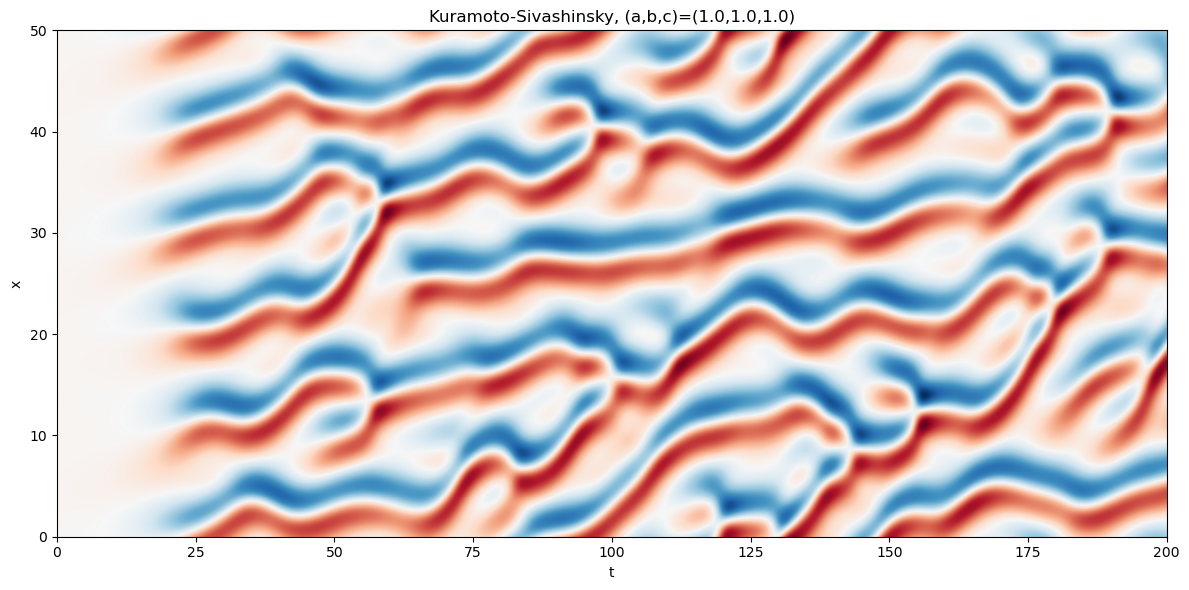

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)


# Parameters
Lx = 50
Nx = 1024
a = 1e0
b = 1e0
c = 1e0
dealias = 3/2
stop_sim_time = 200
timestepper = d3.SBDF2
timestep = 2e-3
dtype = np.float64

# Define bases: periodic
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=dtype)
xbasis = d3.RealFourier(xcoord, size=Nx, bounds=(0, Lx), dealias=dealias)

# Fields
u = dist.Field(name='u', bases=xbasis)

# Define operators
dx = lambda A: d3.Differentiate(A, xcoord)

# Problem
problem = d3.IVP([u], namespace=locals())
# problem.add_equation("dt(u) - a*dx(dx(u)) - b*dx(dx(dx(u))) = - u*dx(u)")
problem.add_equation("dt(u) + dx(dx(dx(dx(u)))) + dx(dx(u)) = -u*dx(u)")

# ic = gaussian_filter1d(np.random.random(x.shape), 10)
# dx_val = (2*np.pi)/len(u['g'])
# u['g'] = ic/(np.sum(ic)*dx_val)

# Initial conditions
x = dist.local_grid(xbasis)
# n = 20
# u['g'] = np.log(1 + np.cosh(n)**2/np.cosh(n*(x-0.2*Lx))**2) / (2*n)
from scipy.ndimage import gaussian_filter1d
ic = gaussian_filter1d(np.random.random(x.shape), 10)
dx_val = (2 * np.pi)/len(u['g'])
u['g'] = ic / (np.sum(ic)*dx_val)

## Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

## Main loop
u.change_scales(1)
u_list = [np.copy(u['g'])]
t_list = [solver.sim_time]
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    if solver.iteration % 50 == 0:
        u.change_scales(1)
        u_list.append(np.copy(u['g']))
        t_list.append(solver.sim_time)

## Plotting
plt.figure(figsize=(12, 6))
plt.pcolormesh(np.array(t_list), x.ravel(), np.array(u_list).T, cmap='RdBu_r', shading='gouraud', rasterized=True)
plt.xlim(0, stop_sim_time)
plt.ylim(0, Lx)
plt.xlabel('t')
plt.ylabel('x')
plt.title(f'Kuramoto-Sivashinsky, (a,b,c)=({a},{b},{c})')
plt.tight_layout()